# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16, resnet
from tensorflow.keras import optimizers
from tensorflow.python.keras.layers import Dense,Dropout,Flatten, Conv2D, MaxPool2D
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

print('Train files count:', len(train_files))
print('Test files count:', len(test_files))

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            y_train_labels = tf.keras.utils.to_categorical(y, num_classes=2)
            yield (x, y_train_labels)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

Train files count: 25000
Test files count: 12500


## Визуализируем примеры для обучения

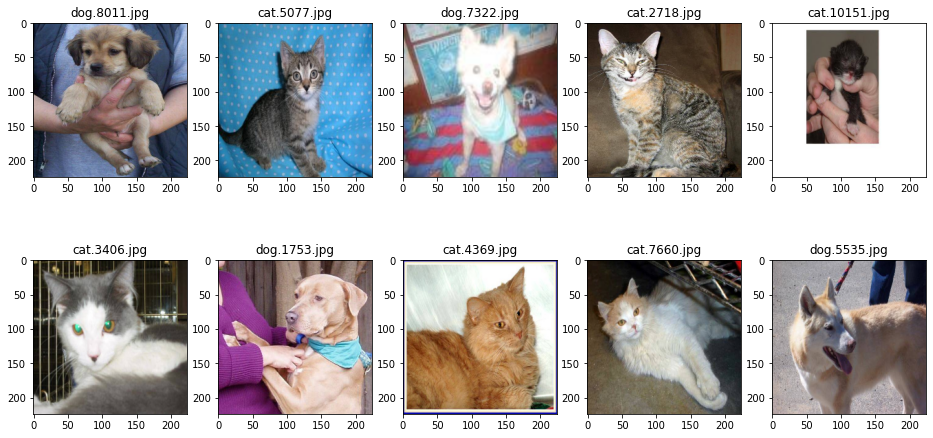

In [3]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Добавляем полносвязный слой

https://www.ahmedbesbes.com/blog/introduction-to-cnns

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False



x = base_model.layers[-5].output
x = Conv2D(32, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)


model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Запускаем обучение

In [5]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 25s 2s/step - loss: 41.9147 - accuracy: 0.4955 - val_loss: 4.0757 - val_accuracy: 0.4000
Epoch 2/100
10/10 [==============================] - 25s 3s/step - loss: 7.3853 - accuracy: 0.5757 - val_loss: 2.9027 - val_accuracy: 0.4000
Epoch 3/100
10/10 [==============================] - 25s 3s/step - loss: 3.3048 - accuracy: 0.5887 - val_loss: 1.5720 - val_accuracy: 0.4000
Epoch 4/100
10/10 [==============================] - 24s 2s/step - loss: 2.2535 - accuracy: 0.6013 - val_loss: 1.0706 - val_accuracy: 0.6000
Epoch 5/100
10/10 [==============================] - 26s 3s/step - loss: 1.9550 - accuracy: 0.5337 - val_loss: 0.9570 - val_accuracy: 0.6000
Epoch 6/100
10/10 [==============================] - 27s 3s/step - loss: 1.5554 - accuracy: 0.5793 - val_loss: 0.8268 - val_accuracy: 0.6000
Epoch 7/100
10/10 [==============================] - 27s 3s/step - loss: 1.4138 - accuracy: 0.5664 - val_loss: 1.0702 - val_accuracy: 0.2000
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 30s 3s/step - loss: 0.1796 - accuracy: 0.9705 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 31s 3s/step - loss: 0.1627 - accuracy: 0.9185 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 31s 3s/step - loss: 0.1846 - accuracy: 0.9437 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 33s 3s/step - loss: 0.1824 - accuracy: 0.9366 - val_loss: 0.1387 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 32s 3s/step - loss: 0.1613 - accuracy: 0.9323 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 32s 3s/step - loss: 0.1369 - accuracy: 0.9520 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 65/100
10/10 [==============================] - 30s 3s/step - loss: 0.1551 - accuracy: 0.9484 - val_loss: 1.0729e-04 - val_accuracy: 1.0000
Ep

In [11]:
model.save('cats-dogs-vgg16.hdf5')

## Загрузка обученной модели

model = tf.keras.models.load_model('cats-dogs-vgg16-final.hdf5')
model.summary()

## Предсказания на проверочной выборке

In [12]:
test_files = glob('test/*.jpg')

test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files), verbose=True)

12500/12500 [==============================] - 1263s 101ms/step


In [13]:
test_pred

array([[1.0000000e+00, 8.6323171e-09],
       [9.9985290e-01, 1.4711847e-04],
       [4.0501209e-22, 1.0000000e+00],
       ...,
       [3.9753588e-16, 1.0000000e+00],
       [1.0000000e+00, 6.0467509e-10],
       [1.1500841e-23, 1.0000000e+00]], dtype=float32)

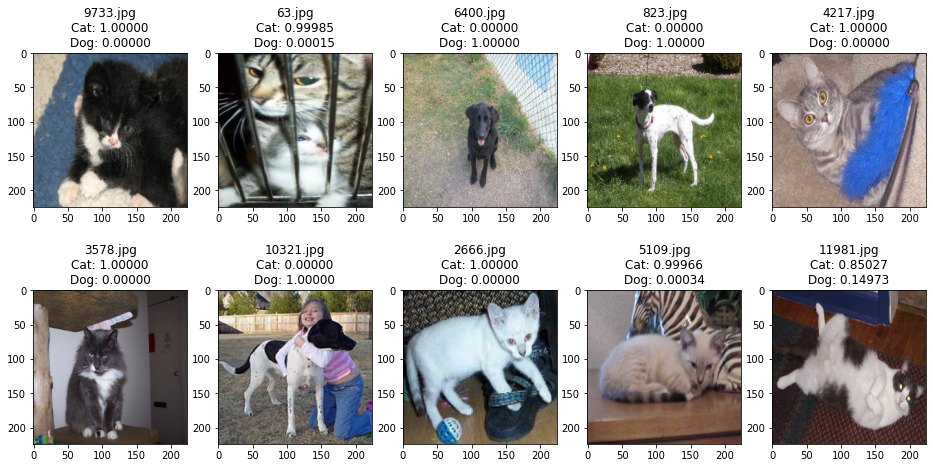

In [14]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title(f'{os.path.basename(path)}\nCat: {score[0]:.5f}\nDog: {score[1]:.5f}')
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [15]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score[1]))

In [10]:
# LogLoss = 1.04979